<h1><strong>Bert를 이용한 우수 Essay 분석 </strong></h1>

구글의 버트 모형을 활용하여 글을 잘 썼는지 예측하는 인공지능을 구현

이 코드는 다음을 참조하여 docx파일을 전저리하여 BERT 모델에 적용하도록 수정하였습니다. 공부하는데 도움을 주신 kimwoonggon님께 감사드립니다. ㅎ
ref: https://github.com/kimwoonggon/publicservant_AI

<h2><strong>버트 사전학습 모형 가져오기</strong></h2>

https://github.com/google-research/bert 에 접속하셔서 BERT-Base, Multilingual Cased: 104 languages, 12-layer, 768-hidden, 12-heads, 110M parameters 파일을 다운 받으시길 바랍니다.

![대체 텍스트](https://i.imgur.com/RlutYyW.png)

<p>사전 학습 모형을 다운 받으셨다면, Colab에서 활용하기 위해 구글 GDRIVE에 업로드 하시길 바랍니다.</p>

![대체 텍스트](https://i.imgur.com/uM97zAQ.png)



 <u>런타임->런타임 유형 변경에서 GPU를 꼭 선택하시기 바랍니다.</u><br>
그리고 데이터는 구글 G드라이브에 넣어 두었습니다. 사정에 맞게 폴더 경로를 변경하시기 바랍니다.</p>


In [2]:
# wget을 활용해서 bert 모델 다운로드 가능
import os
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

import zipfile
import shutil
         
bert_zip = zipfile.ZipFile('multi_cased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')
 
bert_zip.close()

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree("bert/multi_cased_L-12_H-768_A-12", "bert")

--2020-02-03 03:52:20--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip.1’

multi_cased_L-12_H- 100%[===================>] 632.19M   165MB/s    in 3.9s    

2020-02-03 03:52:24 (161 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip.1’ saved [662903077/662903077]



<h2><strong>Essay 분석 예측</strong></h2>


 #### 구글 드라이브와 Colab을 연동합니다. 로컬컴퓨터에서 테스트하려면 실행하지 않아도 됨. 단 컴퓨터 사양이 좋아야 하죠. 저는  GTX2060 super를 사용해서 테스트하였습니다.



In [3]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [1]:
###로컬로 실행하기위해서 디렉토리 설정(자신의 디렉토리에 맞게 설정하세요.)
import os
os.listdir('C:/Users/82107/Projects/KERAS_Bert/EssayFit_Analysis')

['.ipynb_checkpoints',
 'bert',
 'EssayFit_AI_sentiment_application.ipynb',
 'nsmc']

- Colab에서 Bert 모형을 가지고 있는 폴더를 지정해줍니다. 로컬에서 실행할때는 해당 디렉토리를 지정하시면 됩니다.

- 파이썬 명령어 os.listdir(path)를 활용하여 폴더가 잘 있는지 확인하면서 진행합니다.

In [2]:
path = "C:/Users/82107/Projects/KERAS_Bert/EssayFit_Analysis"

텐서플로우, 판다스, 넘파이, 케라스 등 필요한 모듈들을 임포트합니다

In [28]:
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

import codecs
from tqdm import tqdm
import shutil

In [4]:
import warnings
import tensorflow as tf
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

케라스에서 Bert 활용을 쉽게 만들어주는 모듈 keras-bert를 설치합니다<br>그리고 Adam optimizer의 수정판인 keras-radam 모듈을 임포트합니다.

In [12]:
!pip install keras-bert
!pip install keras-radam

  Created wheel for keras-bert: filename=keras_bert-0.81.0-py3-none-any.whl size=37917 sha256=b9afd0c51515021fef766dc908f6bc911e5f73d3c3142f1ff61d40ec11514efd
  Stored in directory: c:\users\82107\appdata\local\pip\cache\wheels\ee\d9\2a\75b40df359ab9096f06e55804ca64fbb2592a6ff77345c5fa7
  Created wheel for keras-transformer: filename=keras_transformer-0.32.0-py3-none-any.whl size=13271 sha256=0d87373a065f4229bb8c6b03d1b04dc933886c108ccc1195036335c11fbf858a
  Stored in directory: c:\users\82107\appdata\local\pip\cache\wheels\45\b4\8b\5bc34b8f664af4f40fd27cc6c302ee3d6c7f29f181686f7ba5
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-py3-none-any.whl size=7557 sha256=93e67bc88666a2f28356df9cb13f9e2d488c78902d4e72d63425e1afd403eef1
  Stored in directory: c:\users\82107\appdata\local\pip\cache\wheels\13\b1\3b\13b632f78162148b123cddad1e0e3786df45ec37cac86dd998
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-py3-none-any.whl size=15379 sha256=20c43642b

ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "c:\users\82107\anaconda3\envs\keras\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "c:\users\82107\anaconda3\envs\keras\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\82107\anaconda3\envs\keras\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "c:\users\82107\anaconda3\envs\keras\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\

  Created wheel for keras-radam: filename=keras_radam-0.15.0-py3-none-any.whl size=14690 sha256=85a1166bfdde0cdbd1bcbf020716face9e73e14d8ecfce2d7b106b06ad3a97fa
  Stored in directory: c:\users\82107\appdata\local\pip\cache\wheels\7c\69\5c\dfbaf4796af41419a83587eec4cddc231592a7ae4f8f53aaf4
Successfully built keras-radam


ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "c:\users\82107\anaconda3\envs\keras\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "c:\users\82107\anaconda3\envs\keras\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\82107\anaconda3\envs\keras\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "c:\users\82107\anaconda3\envs\keras\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\

keras-bert 라이브러리에서 버트 모형 활용에 필요한 모듈들을 임포트합니다

In [5]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

In [6]:
os.listdir('bert')

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'bert_model.ckpt.meta',
 'vocab.txt']

In [30]:
os.listdir('essay/01_Harvard')#분석할 데이터를 확인합니다.

['HarvardCS40COMMUNITY-03.docx',
 'HarvardCS40CULTURE-07.docx',
 'HarvardCS40EXPERIENCE-04.docx',
 'HarvardCS40INTELLECTUAL-01.docx',
 'HarvardCS40UNIQUE-02.docx',
 'HarvardCS45Experience-06.docx',
 'HarvardCS45INTELLECTUAL-05.docx',
 'HarvardCS45INTELLECTUAL-06.docx',
 'HarvardEssays.txt',
 'HarvardPS35P1-03.docx',
 'HarvardPS35P2-02.docx',
 'HarvardPS40P3-04.docx',
 'HarvardPS40P5-1.docx',
 'HarvardPS45P1-04.docx',
 'HarvardPS45P1-05.docx',
 'HarvardPS45P2-04.docx',
 'HarvardPS45P2-05.docx']

버트 모형을 훈련시킬 train 데이터와 test데이터를 pandas 테이블 형식으로 로드합니다

In [1]:
#학습할 txt 파일을 불러와서 text_input_train 리스트에 모두 담습니다.
text_input_train=[]

file=open("essay/01_Harvard/data/"+"ratings_train.txt", "r",  encoding='utf8')

while (1):
    line=file.readline()

    try:escape=line.index('\n')
    except:escape=len(line)
    
    if line:
        text_input_train.append(line[0:escape])
    else:
        break
    
file.close()

FileNotFoundError: [Errno 2] No such file or directory: 'essay/01_Harvard/data/ratings_train.txt'

In [47]:
#DataCleaning 함수
def _re_text(input_sentence):
    input_sentence = re.sub('[-=+,#/\?:^$@*\"※~&%ㆍ!』\\''‘|\(\)\[\]\<\>`\'…》]', ' ', str(input_sentence))
    input_sentence2 = input_sentence.strip()
    input_sentence3 = " ".join(re.split("\s+", input_sentence2, flags=re.UNICODE))
    output_sentence = input_sentence3.split('.')

    #BERT에 입력하기 위해서 문장을 데이터프레임으로 전환합니다.
    df = pd.DataFrame(output_sentence)
    df['label'] = 1
    df.columns = ['document','label']
    output_sentence = df
    
    return output_sentence

In [50]:
#BERT 모델에 train 데이터를 입력할 수 있도록 전처리 완료.
train_input = _re_text(text_input_train)
train_input[:5]

document  label
0       Statistical Physics is a comedy in long shot      1
1   Professor Nir Gov’s lecture held during the s...      1
2   However its application was truly versatile—f...      1
3   Full of curiosity I approached him after the ...      1
4           “Start with ensemble theory ” he advised      1

In [51]:
#train = pd.read_table(train_input)
train = train_input #학습을 위한 입력데이터 준비완료하여 train에 넣어줍니다.

이제 test 데이터 전처리를 합니다.

In [55]:
#txt 파일을 불러와서 text_input_test의 리스트에 모두 담습니다.
text_input_test=[]

file=open("essay/01_Harvard/data/"+"ratings_test.txt", "r",  encoding='utf8')

while (1):
    line=file.readline()

    try:escape=line.index('\n')
    except:escape=len(line)
    
    if line:
        text_input_test.append(line[0:escape])
    else:
        break
    
file.close()

In [56]:
test_input = _re_text(text_input_test)

test = test_input #test를 위한 입력데이터 준비완료하였습니다.
test  # 데이터셋이 데이터프레임에 잘 정리되어있는지 확인합니다.

document  label
0        Statistical Physics is a comedy in long shot      1
1    Professor Nir Gov’s lecture held during the s...      1
2    However its application was truly versatile—f...      1
3    Full of curiosity I approached him after the ...      1
4            “Start with ensemble theory ” he advised      1
5    Though Statistical Physics seemed more of a t...      1
6    Spending weeks with several textbooks I found...      1
7    To understand a system you shall calculate ev...      1
8    This commandment summarizes the physics I had...      1
9    However when we consider a system with a myri...      1
10   Instead physicists construct the ensemble of ...      1
11   The snapshots contain different particle arra...      1
12  ” As far as I understood ensemble theory was s...      1
13   Hypothetically if I were to analyze every act...      1
14   In short the theory states that a state of ma...      1
15   At odds with my existing beliefs this new app...      1
16   Even well designed exercise problems in textb...      1
17   Meanwhile ensemble theory suggested a possibl...      1
18   To successfully manage KSA’s largest internat...      1
19   For example I assigned each of the fifteen vo...      1
20   Despite my efforts in trying to control all a...      1
21   Initially I was clueless as I tried to unders...      1
22   Instead of micromanagement I should have view...      1
23   As the head volunteer I should have been brav...      1
24   Given a second chance to be the head voluntee...      1
25   I designed the events with macroscopic thinki...      1
26   This encouraged the volunteers to be more pro...      1
27  ’ Compared to KSASF the camp became more color...      1
28   Feeling the power of ensemble theory through ...      1
29   I cannot account for every interaction in eve...      1
30   Regardless I now believe that we may find way...      1
31   From a scientist’s viewpoint it may sound ironic      1
32   Still ensemble theory taught me to gaze upon ...      1
33   During a Statistical Physics PH312 class at K...      1
34   After sharing my experiences he warmly smiled...      1
35                                                         1

훈련 및 테스트 데이터가 잘 로드되었습니다.  
**document 칼럼에는 문장이, label 칼럼에는 good(1) bad(0)이 들어가지만, 지금은 1로 데이터 임시로 넣어놨습니다. 나중에 적합한 데이터를 준비해야겠죠.

In [57]:
train

document  label
0        Statistical Physics is a comedy in long shot      1
1    Professor Nir Gov’s lecture held during the s...      1
2    However its application was truly versatile—f...      1
3    Full of curiosity I approached him after the ...      1
4            “Start with ensemble theory ” he advised      1
5    Though Statistical Physics seemed more of a t...      1
6    Spending weeks with several textbooks I found...      1
7    To understand a system you shall calculate ev...      1
8    This commandment summarizes the physics I had...      1
9    However when we consider a system with a myri...      1
10   Instead physicists construct the ensemble of ...      1
11   The snapshots contain different particle arra...      1
12  ” As far as I understood ensemble theory was s...      1
13   Hypothetically if I were to analyze every act...      1
14   In short the theory states that a state of ma...      1
15   At odds with my existing beliefs this new app...      1
16   Even well designed exercise problems in textb...      1
17   Meanwhile ensemble theory suggested a possibl...      1
18   To successfully manage KSA’s largest internat...      1
19   For example I assigned each of the fifteen vo...      1
20   Despite my efforts in trying to control all a...      1
21   Initially I was clueless as I tried to unders...      1
22   Instead of micromanagement I should have view...      1
23   As the head volunteer I should have been brav...      1
24   Given a second chance to be the head voluntee...      1
25   I designed the events with macroscopic thinki...      1
26   This encouraged the volunteers to be more pro...      1
27  ’ Compared to KSASF the camp became more color...      1
28   Feeling the power of ensemble theory through ...      1
29   I cannot account for every interaction in eve...      1
30   Regardless I now believe that we may find way...      1
31   From a scientist’s viewpoint it may sound ironic      1
32   Still ensemble theory taught me to gaze upon ...      1
33   During a Statistical Physics PH312 class at K...      1
34   After sharing my experiences he warmly smiled...      1
35                                                         1


- bert 훈련을 위한 사전 설정을 합니다. SEQ_LEN은 문장의 최대 길이입니다. SEQ_LEN 보다 문장의 길이가 작다면 남은 부분은 0이 채워지고, 만약에 SEQ_LEN보다 문장 길이가 길다면 SEQ_LEN을 초과하는 부분이 잘리게 됩니다.  
- BATCH_SIZE는 메모리 초과 같은 문제를 방지하기 위해 작은 수인 16으로 정했습니다. 그리고 총 훈련 에포크 수는 2로 정했습니다. 학습율(LR;Learning rate)은 1e-5로 작게 정했습니다.  
- pretrained_path는 bert 사전학습 모형이 있는 폴더를 의미합니다.
- 그리고 우리가 분석할 문장이 들어있는 칼럼의 제목인 document와 good or bad를  알려주는 칼럼을 label로 정해줍니다


In [58]:
SEQ_LEN = 128
BATCH_SIZE = 16
EPOCHS=2
LR=1e-5

pretrained_path ="bert"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

#분석할 문장의 데이터 컬럼을 구분. 입력데이터를 이런형식으로 데이터를 preprocessing해야 합니다.
DATA_COLUMN = "document"
LABEL_COLUMN = "label"

vocab.txt에 있는 단어에 인덱스를 추가해주는 token_dict라는 딕셔너리를 생성합니다.  
우리가 분석할 문장이 토큰화가 되고, 그 다음에는 인덱스(숫자)로 변경되어서 버트 신경망에 인풋으로 들어게 됩니다.

In [59]:
token_dict = {} #토큰 딕셔너리로 만들거에요.
with codecs.open(vocab_path, 'r', 'utf8') as reader: #경로에 있는 vocab.txt를 불러와서
    for line in reader: #한줄씩 읽고
        token = line.strip() #앞뒤 공백을 제거하고 token에 넣고
        if "_" in token: #만약 토큰에 _가 있으면 ""을 이용해서 변환(삭제)해주고
          token = token.replace("_","")
          token = "##" + token # 토큰에다가 ##를 붙여서 토큰을 결합한다. ##는 토큰연산자이다.
        token_dict[token] = len(token_dict) #딕셔너리로 변환

In [60]:
token_dict #어떻게 되는지 확인해봅니다. 숫자로 번호를 매겼네요. 

{'[PAD]': 0,
 '[unused1]': 1,
 '[unused2]': 2,
 '[unused3]': 3,
 '[unused4]': 4,
 '[unused5]': 5,
 '[unused6]': 6,
 '[unused7]': 7,
 '[unused8]': 8,
 '[unused9]': 9,
 '[unused10]': 10,
 '[unused11]': 11,
 '[unused12]': 12,
 '[unused13]': 13,
 '[unused14]': 14,
 '[unused15]': 15,
 '[unused16]': 16,
 '[unused17]': 17,
 '[unused18]': 18,
 '[unused19]': 19,
 '[unused20]': 20,
 '[unused21]': 21,
 '[unused22]': 22,
 '[unused23]': 23,
 '[unused24]': 24,
 '[unused25]': 25,
 '[unused26]': 26,
 '[unused27]': 27,
 '[unused28]': 28,
 '[unused29]': 29,
 '[unused30]': 30,
 '[unused31]': 31,
 '[unused32]': 32,
 '[unused33]': 33,
 '[unused34]': 34,
 '[unused35]': 35,
 '[unused36]': 36,
 '[unused37]': 37,
 '[unused38]': 38,
 '[unused39]': 39,
 '[unused40]': 40,
 '[unused41]': 41,
 '[unused42]': 42,
 '[unused43]': 43,
 '[unused44]': 44,
 '[unused45]': 45,
 '[unused46]': 46,
 '[unused47]': 47,
 '[unused48]': 48,
 '[unused49]': 49,
 '[unused50]': 50,
 '[unused51]': 51,
 '[unused52]': 52,
 '[unused53]': 53

- Tokenizer 클래스를 상속받아서 inherit_Tokennizer라는 클래스를 재정의하고 _tokenize 함수를 새로 작성합니다. 왜 상속을 해서 함수를 새로 만들어야 하냐면, 만약 원래 클래스를 그대로 사용하면 입력한 문장이 "완전자모분리"됩니다. 예를 들어서 "인공지능 할 수 있다" 라는 문장이 있다면 원래 "인,##공,##지,##능,할,수,있다"로 분해가 되어야 하는데, ㅇ,##ㅣ,##ㄴ,ㄱ,##ㅗ,##ㅇ,ㅈ,##ㅣ,##ㄴ,##ㅡ,##ㅇ 이런 식으로 토큰화가 됩니다.

- 두칸 아래에서 보시겠지만, inherit_Tokenizer클래스는 문장을 토큰화하는 기능을 합니다. 

- BERT의 토큰화는 단어를 분리하는 토큰화 방식입니다. wordpiece(단어조각?) 방식이라고 하는데, 이는 한국어를 형태소로 꼭 변환해야 할 문제를 해결해주며, 의미가 있는 단어는 밀접하게 연관이 되게 하는 장점까지 갖추고 있습니다.
- 단어의 첫 시작은 ##가 붙지 않지만, 단어에 포함되면서 단어의 시작이 아닌 부분에는 ##가 붙는 것이 특징입니다. 추가설명하면 각 토큰(더이상 분리할 수 없는 문자열의 조각)으로 ##는 단어이 구성문자들을 합친 것이라는 의미

In [61]:
class inherit_Tokenizer(Tokenizer):
  def _tokenize(self, text):
        if not self._cased:
            text = text
            
            text = text.lower()
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:
                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [62]:
tokenizer = inherit_Tokenizer(token_dict)

토큰화가 잘 되었는지 확인해 봅니다.
버트 모형은 문장 앞에 꼭 [CLS]라는 문자가 위치하고, [SEP]라는 문자가 끝에 위치합니다.  
[CLS]는 문장의 시작, [SEP]는 문장의 끝을 의미합니다.

In [63]:
tokenizer.tokenize("As far as I understood, ensemble theory was similar to understanding the theme of a movie by watching a preview that only consists of the important scenes. Hypothetically, if I were to analyze every actor, every line, and every frame, it would actually hinder me from grasping the overall message of the film. In short, the theory states that a state of matter can be understood without knowing the movements of each and every particle. At odds with my existing beliefs, this new approach refused to settle in my brain. Even well-designed exercise problems in textbooks could not save me from drowning in confusion. ")

['[CLS]',
 'as',
 'far',
 'as',
 'i',
 'understood',
 ',',
 'ensemble',
 'theory',
 'was',
 'similar',
 'to',
 'understanding',
 'the',
 'theme',
 'of',
 'a',
 'movie',
 'by',
 'watching',
 'a',
 'pre',
 '##view',
 'that',
 'only',
 'consists',
 'of',
 'the',
 'important',
 'scenes',
 '.',
 'hy',
 '##pot',
 '##het',
 '##ically',
 ',',
 'if',
 'i',
 'were',
 'to',
 'anal',
 '##y',
 '##ze',
 'every',
 'actor',
 ',',
 'every',
 'line',
 ',',
 'and',
 'every',
 'frame',
 ',',
 'it',
 'would',
 'actually',
 'hin',
 '##der',
 'me',
 'from',
 'gras',
 '##ping',
 'the',
 'overall',
 'message',
 'of',
 'the',
 'film',
 '.',
 'in',
 'short',
 ',',
 'the',
 'theory',
 'states',
 'that',
 'a',
 'state',
 'of',
 'matter',
 'can',
 'be',
 'understood',
 'without',
 'knowing',
 'the',
 'movements',
 'of',
 'each',
 'and',
 'every',
 'particle',
 '.',
 'at',
 'odd',
 '##s',
 'with',
 'my',
 'existing',
 'beliefs',
 ',',
 'this',
 'new',
 'approach',
 'refused',
 'to',
 'settle',
 'in',
 'my',
 'brain'

우리가 로드하였던 네이버 영화 댓글 감성분석 데이터를 **버트 모형의 입력에 맞게 변형해주는 함수**를 정의합니다.

함수 내부에 tokenizer.encode 함수가 버트 모형을 토큰화해주고 토큰화 된 단어를 인덱스에 맞게 숫자로 바꿔주게 됩니다.

In [64]:
def convert_data(data_df):
    global tokenizer
    indices, targets = [], [] 
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN) #tokenized된 문자를 숫자로 모두 바꿔준다. encode
        indices.append(ids)
        targets.append(data_df[LABEL_COLUMN][i])
    items = list(zip(indices, targets))
    
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)


    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [65]:
train_x, train_y = load_data(train)
test_x, test_y = load_data(test)

100%|██████████| 36/36 [00:00<00:00, 4002.41it/s]


- 사전학습된 버트 모델의 인풋은 문장 토큰화가 숫자로 바뀐 것과, 앞문장인지 뒷문장인지 알려주는 문장 순서 벡터가 들어갑니다. 우리는 문장 하나를 가지고만 훈련할 것이므로 순서 벡터는 모두 0으로 통일합니다.

- 그리고 파인튜닝 시에는 문장 안에 일부 단어를 가리는 마스킹은 사용하지 않습니다.

In [66]:
train_x

[array([[  101, 55952, 44939, ...,     0,     0,     0],
        [  101, 13853, 10414, ...,     0,     0,     0],
        [  101, 13800, 10474, ...,     0,     0,     0],
        ...,
        [  101, 10939,   169, ...,     0,     0,     0],
        [  101, 10662, 57535, ...,     0,     0,     0],
        [  101,   102,     0, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

**버트 모형에 들어갈 인풋은 토큰, 세그먼트, 포지션으로 구성됩니다.**  
버트에 인풋으로 들어가는 토큰은 문장을 토크나이징 한 후, 인덱스 번호를 매긴 것입니다.  
세그먼트는 예를 들어 문장이 두 개가 있다면, 앞의 문장과 뒤의 문장을 구분하는 것입니다.  
포지션 임베딩은 단순히 단어의 위치를 말합니다.

토큰, 세그먼트, 포지션을 인풋으로 버트 모형에 넣으면 기하학적인 문장 공간으로 임베딩이 됩니다.

![대체 텍스트](https://i.imgur.com/l9BTao3.png)

#### 이해가 안 가실 수 있는데, 버트 인풋을 문장으로 예를 들어 만들어 보겠습니다.
#### 인풋은 총 2개가 들어갑니다
- **(토큰)** 첫번째 인풋은 토큰화 된 것이 인덱싱되어 숫자로 변환된 것  

- **(세그멘트)** 두번째 인풋은 앞문장인지 뒷문장인지 알려주는 숫자들입니다. 이번 튜토리얼에서는 파인튜닝 과정이라 앞문장 뒷문장 구분을 안하기 때문에 모두 0으로 하였습니다.  

- **(포지션)** 단어 순서에 따라서 자동으로 부여됩니다.


In [67]:
def sentence_convert_data(data):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data))):
        print(tokenizer.tokenize(data[i]))
        ids, segments = tokenizer.encode(data[i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def sentence_load_data(sentences):#sentence는 List로 받는다
           
    data_x = sentence_convert_data(sentences)

    return data_x

In [69]:
sentence_load_data(["As far as I understood, ensemble theory was similar to understanding the theme of a movie by watching a preview that only consists of the important scenes. Hypothetically, if I were to analyze every actor, every line, and every frame, it would actually hinder me from grasping the overall message of the film. In short, the theory states that a state of matter can be understood without knowing the movements of each and every particle. At odds with my existing beliefs, this new approach refused to settle in my brain. Even well-designed exercise problems in textbooks could not save me from drowning in confusion. ", "As far as I understood, ensemble theory was similar to understanding the theme of a movie by watching a preview that only consists of the important scenes. Hypothetically, if I were to analyze every actor, every line, and every frame, it would actually hinder me from grasping the overall message of the film. In short, the theory states that a state of matter can be understood without knowing the movements of each and every particle. At odds with my existing beliefs, this new approach refused to settle in my brain. Even well-designed exercise problems in textbooks could not save me from drowning in confusion. "])

100%|██████████| 2/2 [00:00<00:00, 334.19it/s]

['[CLS]', 'as', 'far', 'as', 'i', 'understood', ',', 'ensemble', 'theory', 'was', 'similar', 'to', 'understanding', 'the', 'theme', 'of', 'a', 'movie', 'by', 'watching', 'a', 'pre', '##view', 'that', 'only', 'consists', 'of', 'the', 'important', 'scenes', '.', 'hy', '##pot', '##het', '##ically', ',', 'if', 'i', 'were', 'to', 'anal', '##y', '##ze', 'every', 'actor', ',', 'every', 'line', ',', 'and', 'every', 'frame', ',', 'it', 'would', 'actually', 'hin', '##der', 'me', 'from', 'gras', '##ping', 'the', 'overall', 'message', 'of', 'the', 'film', '.', 'in', 'short', ',', 'the', 'theory', 'states', 'that', 'a', 'state', 'of', 'matter', 'can', 'be', 'understood', 'without', 'knowing', 'the', 'movements', 'of', 'each', 'and', 'every', 'particle', '.', 'at', 'odd', '##s', 'with', 'my', 'existing', 'beliefs', ',', 'this', 'new', 'approach', 'refused', 'to', 'settle', 'in', 'my', 'brain', '.', 'even', 'well', '-', 'designed', 'exercise', 'problems', 'in', 'text', '##books', 'could', 'not', 'sav

[array([[   101,  10146,  13301,  10146,    177,  71183,    117,  15576,
          17820,  10134,  13213,  10114,  37149,  10105,  26648,  10108,
            169,  18379,  10155,  84532,    169,  12229,  30512,  10189,
          10893,  20963,  10108,  10105,  12452,  32483,    119,  15165,
          37604,  13358,  52917,    117,  12277,    177,  10309,  10114,
         106615,  10157,  10870,  14234,  14066,    117,  14234,  12117,
            117,  10111,  14234,  31532,    117,  10271,  10894,  24376,
          19911,  11304,  10911,  10188,  90097,  15398,  10105,  20947,
          30514,  10108,  10105,  10458,    119,  10106,  13716,    117,
          10105,  17820,  16316,  10189,    169,  11388,  10108,  27904,
          10944,  10347,  71183,  13663, 104862,  10105,  42641,  10108,
          11948,  10111,  14234,  88635,    119,  10160, 104356,  10107,
          10169,  15127,  26636,  75528,    117,  10531,  10751,  23068,
          29622,  10114,  90424,  10106,  15127,  3

이해가 되셨는지요?  
구글 깃허브에서 다운받았던 사전학습된 모델을 로드합니다.

In [70]:
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,)

모델의 구조를 확인합니다.  
총 12층의 트랜스포머 계층이 있음을 확인할 수 있습니다.


In [71]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
__________________________________________________________________________________________________
Embedding-

가장 중요한 부분인데요, 사전학습 파일을 로드하여, 우리가 불러들였던 사전학습 모델을 변형해줍니다.  
  

input으로는 우리가 문장을 토큰화 하여 숫자로 변형시켜주었던 **토큰 벡터와**, 앞문장인지 뒷문장인지 알려주는 **세그멘트** 두 가지가 되겠습니다.  
  
즉 인풋은 inputs = modle.inputs[:2]로 정의하였습니다.  
  
  
그리고 output은 일단 사전학습 모델을 약간 잘라줍니다.(outputs=Dense(1)) 맨 위 3층을 잘라 낸다음에 잘라낸 부분에 good or bad 알려주는 **Dense(1)을 사전학습 모델에 애드온 시켜 줍니다.**  

Dense(1)은 아웃풋이 하나로, **문장이 good에 가까우면 0에 가까운 값**을, **bad에 가까우면 1에 가까운 값**을 출력해주는 레이어입니다.



그리고 사전 설치하였던 Radam을 활용하여 deep learning의 기울기 강하 훈련을 하도록 정해줍니다. 그 다음에 bert_model을 return해 줍니다.

In [72]:
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2] #모델이 있는 트랜스포머 계층을 리스트라고 하면 맨 위 2개가 인풋이 됩니다.Input-Token (InputLayer), Input-Segment (InputLayer) 
  dense = model.layers[-3].output # 요건 아웃풋


  outputs = keras.layers.Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                              name = 'real_output')(dense)



  bert_model = keras.models.Model(inputs, outputs)
  bert_model.compile(
      optimizer=RAdam(learning_rate=0.00001, weight_decay=0.0025),
      loss='binary_crossentropy',
      metrics=['accuracy'])
  
  return bert_model
  

**모델의 FLOW를 확인해 보도록 하겠습니다.**

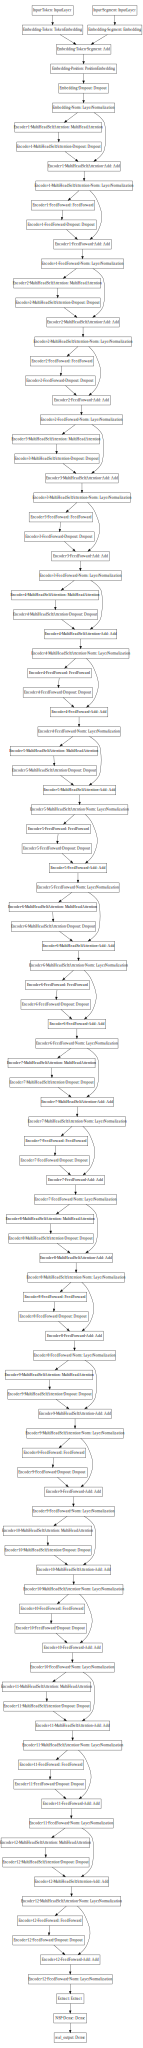

In [74]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


SVG(model_to_dot(get_bert_finetuning_model(model)).create(prog='dot', format='svg'))


bert_model을 get_bert_finetuning_model 함수로 불러들입니다.
이 다음에 bert_model.fit을 활용하여 버트 모형 파인튜닝을 시작하게 됩니다.
실시간으로 테스트 데이터에 대한 정확도를 알기 위해 validation_data = (test_x, test_y)로 정하였습니다.

** 0000 에포크 만에 정확도가 00000(아직 모름)%에 도달함을 알 수 있습니다.**  
  

In [ ]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs=2, batch_size=16, verbose = 1, validation_data=(test_x, test_y), shuffle=True)

Train on 36 samples, validate on 36 samples
Epoch 1/2


In [ ]:
###################################################  여기까지작업했음. 잘 작동하는거 확인 후 Realdata로 트레이닝시켜볼 것입니다.

재사용을 위해 bert_model을 지드라이브에 저장해줍니다.

In [0]:
bert_model.save_weights(path+"/bert.h5")

버트 모형을 로드해줍니다. 이미 로드하였던 모델에 계수들만 살짝 얹혀 줍니다.

In [0]:
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights(path+"/bert.h5")

파인튜닝한 버트 모형에 test 데이터 셋을 넣어 평가해 봅니다.
사실 머신러닝에서는 정확도인 accuracy도 중요하지만, **F1 score**가 상당히 중요합니다.
  

긍정문장으로 판별된 문장이 진짜로 **good 문장에 속할 확률**  
  

부정문장으로 판별된 문장이 진짜로 **bad 문장에 속할 확률**  
 **이 두가지를 고려한 종합적인 성능이 F1 score입니다.**

한번 F1-score를 확인해 보겠습니다.


먼저 테스트 데이터를 버트 모형에 넣을 수 있도록 predict_convert_data 함수를 정의해줍니다. <br> 위에 정의한 convert_data 함수와 다른 점은, test 데이터이기 때문에 label은 고려하지 않는다는 점입니다

In [0]:
def predict_convert_data(data_df):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    
    
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def predict_load_data(x): #Pandas Dataframe을 인풋으로 받는다
    data_df = x
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)


    data_x = predict_convert_data(data_df)

    return data_x

In [0]:
test_set = predict_load_data(test)

100%|██████████| 50000/50000 [00:07<00:00, 6339.45it/s]


In [0]:
test_set

[array([[  101,  8911,   100, ...,     0,     0,     0],
        [  101,   175, 54998, ...,     0,     0,     0],
        [  101,  9303, 21711, ...,     0,     0,     0],
        ...,
        [  101,  8924, 67527, ...,     0,     0,     0],
        [  101,  9666, 14423, ...,     0,     0,     0],
        [  101,  9246, 32537, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

테스트 셋으로 예측하기

In [0]:
#예측
preds = bert_model.predict(test_set)

In [0]:
# good이면 1, bad이면 0 출력
preds

array([[0.993587  ],
       [0.6564824 ],
       [0.62195325],
       ...,
       [0.7552352 ],
       [0.00427142],
       [0.3131508 ]], dtype=float32)

In [0]:
from sklearn.metrics import classification_report

In [0]:
y_true = test['label']
# F1 Score 확인
print(classification_report(y_true, np.round(preds,0)))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     24827
           1       0.88      0.88      0.88     25173

    accuracy                           0.88     50000
   macro avg       0.88      0.88      0.88     50000
weighted avg       0.88      0.88      0.88     50000



F1 스코어와 Accuracy가 거의 비슷함을 알 수 있습니다. 훈련이 치우치지 않고 잘 됐음을 알 수 있습니다.( 그러쿤요 ㅠㅠ 제가 수정한 코드가 잘 되면 좋겠지만.)

#### 한번 케라스의 장점을 살려 볼까요?
#### 케라스의 장점은 모델을 쉽게 자르고 붙일 수 있다는 점 같습니다
#### 마지막 768개의 피처 부분을 잘라내서, good or bad 평가의  플롯을 한번 그려보고 상호간 기하학적 관계를 살펴보도록 하겠습니다.

#### 먼저, 마지막 768개 피처를 추출하는 함수를 정의합니다
#### 이번에는 아웃풋이 0과 1 사이의 값이 아닌, 768개의 값을 반환하게 됩니다.
- 수정 주) 이 부분은 테스트를 하지는 않겠습니다. ㅎ

In [0]:
def get_feature_map(model):
  inputs = model.input
  outputs = model.layers[-2].output
  feature_model = Model(inputs, outputs)
  return feature_model

In [0]:
bert_feature = get_feature_map(bert_model)

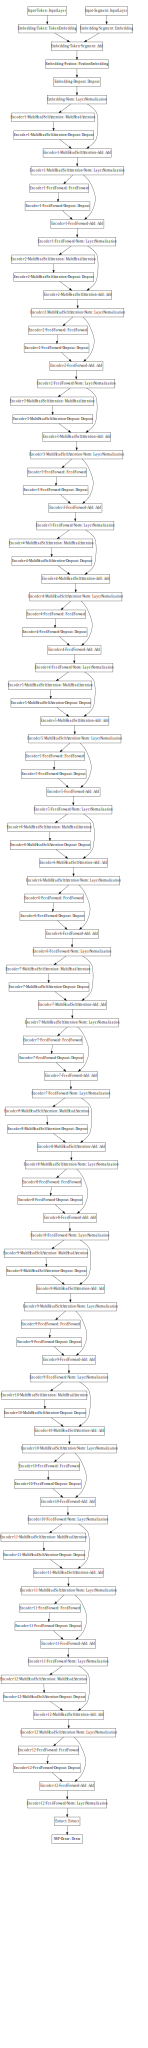

In [0]:
SVG(model_to_dot(bert_feature, dpi=65).create(prog='dot', format='svg'))

마지막 부분을 보시면 768개의 피처가 반환되게 됩니다.

테스트 데이터의 피처들을 반환하고, TSNE 임베딩 플롯을 그려보도록 하겠습니다.

In [0]:
bert_weight_list = bert_feature.predict(test_set)

In [0]:
bert_weight_list

array([[ 0.6768613 , -0.34577873, -0.44642594, ..., -0.46659446,
         0.4760487 ,  0.554863  ],
       [ 0.63960963, -0.21447237,  0.3751952 , ..., -0.75756145,
         0.54507357,  0.64565605],
       [ 0.6462688 , -0.22030291,  0.29965237, ..., -0.76921386,
         0.4767284 ,  0.5631936 ],
       ...,
       [ 0.6250664 , -0.18705241, -0.0571351 , ..., -0.67899805,
         0.45182475,  0.4458032 ],
       [-0.75391245,  0.4165041 ,  0.3838565 , ...,  0.37433255,
        -0.4284077 , -0.4931942 ],
       [ 0.418387  ,  0.01214304,  0.23017944, ..., -0.6176592 ,
         0.23473784,  0.35688388]], dtype=float32)

In [0]:
labels = test['label']

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

마지막 768 차원을 PCA를 사용하여 256차원으로 줄여줍니다.
그 다음 TSNE 알고리즘을 활용하여 3차원으로 축소해 줍니다.
TSNE 알고리즘은 유사한 것끼리 클러스터를 만들어 주는 역할을 합니다.

In [0]:
bert_embedded = PCA(n_components=256).fit_transform(bert_weight_list)
bert_embedded = TSNE(n_components=3).fit_transform(bert_embedded)
bert_embedded

array([[-15.254069 ,  12.572834 ,  -2.8383455],
       [ -1.8160225, -17.949944 ,  -3.7903683],
       [ -3.7930512, -13.10499  ,  -1.4318625],
       ...,
       [ -2.2158408,  -5.778054 ,   5.1145797],
       [  6.4387045, -12.531628 ,  -9.399321 ],
       [-14.548854 ,  -1.8416196,   8.593951 ]], dtype=float32)

bert 임베딩을 pickle 모듈을 활용하여 저장해 줍니다.  

추후 재사용에 쓸 예정입니다.

In [0]:
with open(path+"/bertembedding.pkl", "wb") as f:
  pickle.dump(bert_embedded, f)

저장하였던 임베딩 파일을 로드합니다.

In [0]:
with open(path+"/bertembedding.pkl", "rb") as f:
  bert_embedded = pickle.load(f)

3D로 그리기 위해 matplotlib 모듈들을 로드합니다.

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import seaborn as sns

In [2]:
test

NameError: name 'test' is not defined

In [0]:
def get_tsne_plot(rot1=-20, rot2=100):
  fig = plt.figure(figsize=(5,5))
  ax = Axes3D(fig)
  colors = 'b', 'r'
  labels = 0, 1
  for i, c, label in zip(range(np.shape(bert_embedded)[0]), colors, labels):
    ax.scatter(bert_embedded[test['label']==label,0], bert_embedded[test['label']==label,1], bert_embedded[test['label']==label,2], s=2, c=c, alpha=0.5)
  ax.view_init(rot1, rot2)
  print("rot1:%d" % rot1, "rot2:%d" % rot2)
  plt.legend(labels, loc='upper right')
  plt.show()

긍정(1)과 부정(0)의 임베딩이 잘 되는지 확인해 봅니다.  

긍정 부분의 클러스터와 부정구간의 클러스터가 잘 구분되는 것을 확인하실 수 있습니다.

rot1:-180 rot2:-180


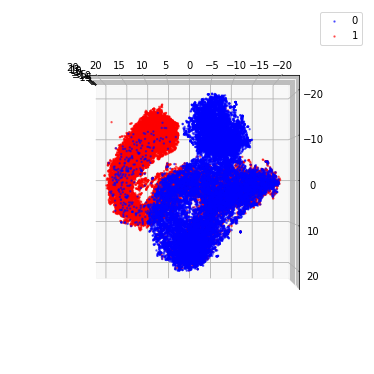

rot1:-135 rot2:-180


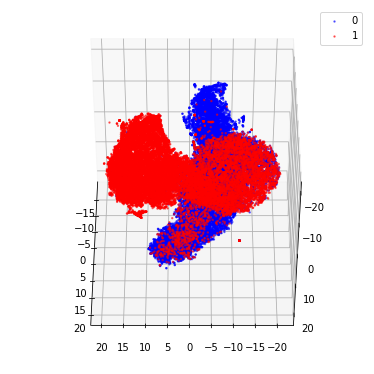

rot1:-90 rot2:-180


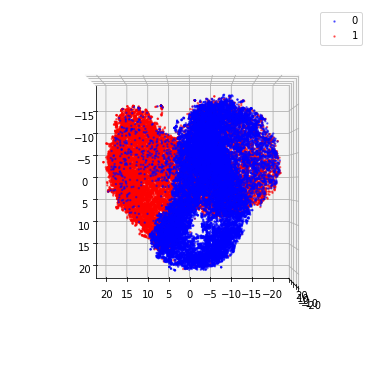

rot1:-45 rot2:-180


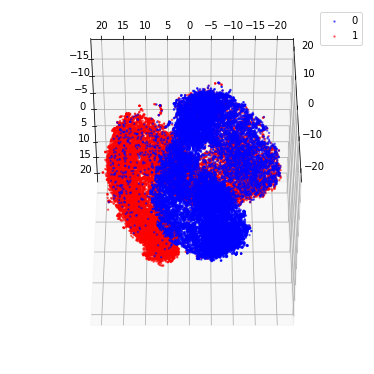

rot1:0 rot2:-180


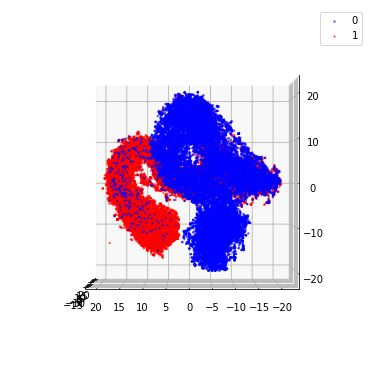

rot1:45 rot2:-180


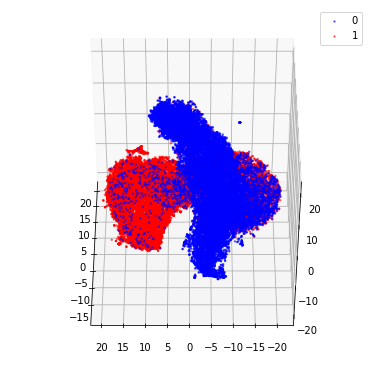

rot1:90 rot2:-180


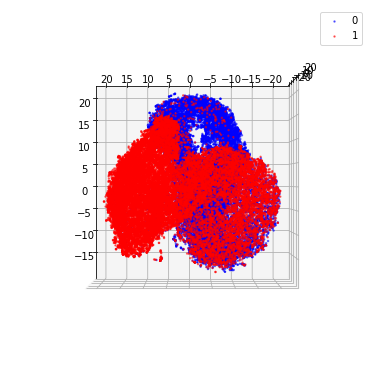

rot1:135 rot2:-180


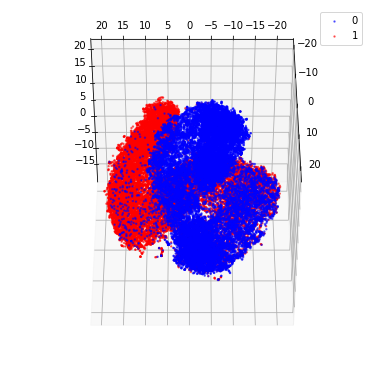

rot1:-180 rot2:-135


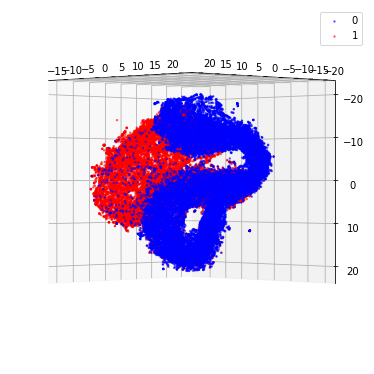

rot1:-135 rot2:-135


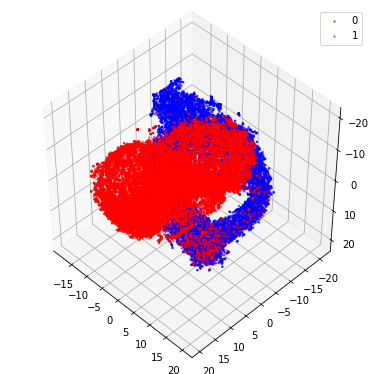

rot1:-90 rot2:-135


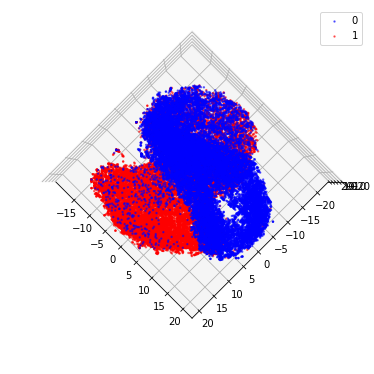

rot1:-45 rot2:-135


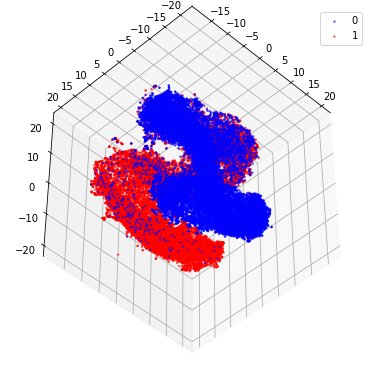

rot1:0 rot2:-135


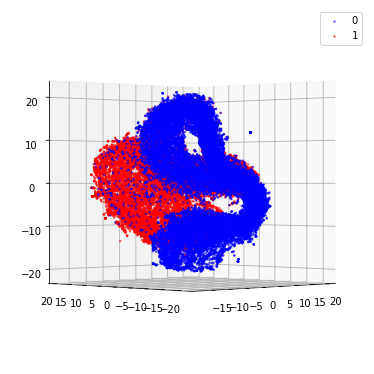

rot1:45 rot2:-135


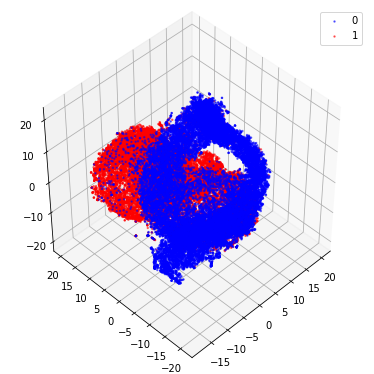

rot1:90 rot2:-135


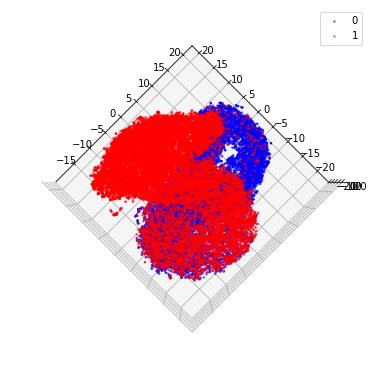

rot1:135 rot2:-135


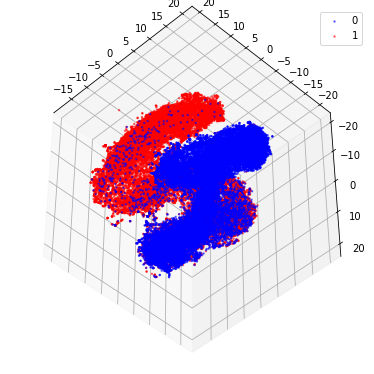

rot1:-180 rot2:-90


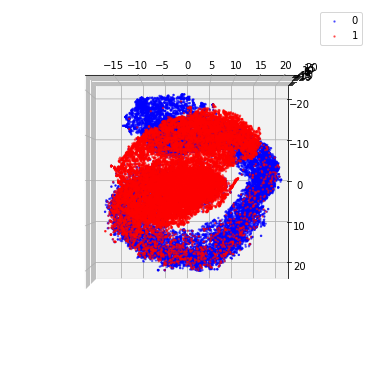

rot1:-135 rot2:-90


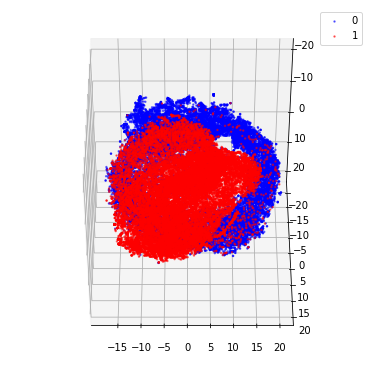

rot1:-90 rot2:-90


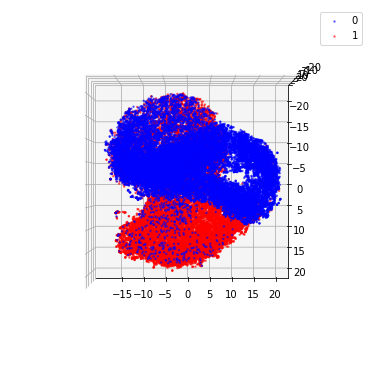

rot1:-45 rot2:-90


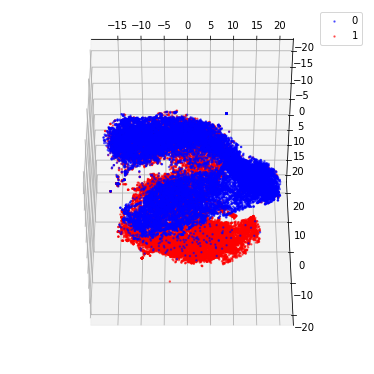

rot1:0 rot2:-90


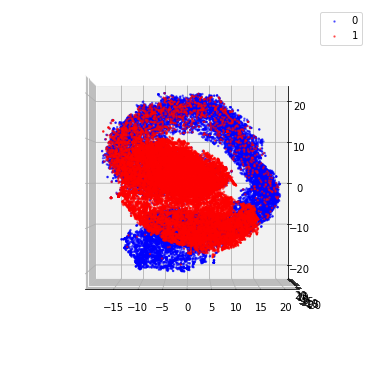

rot1:45 rot2:-90


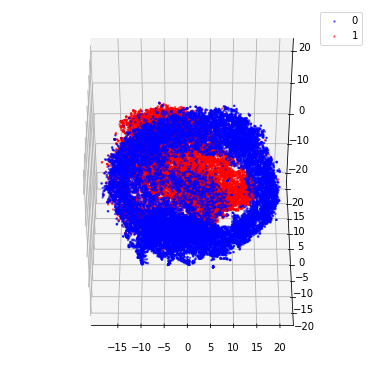

rot1:90 rot2:-90


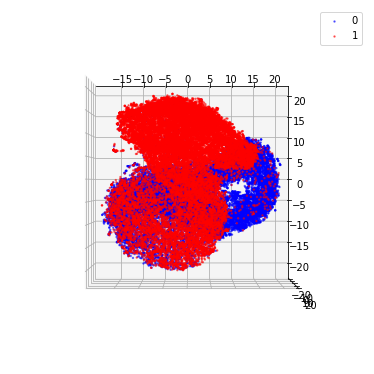

rot1:135 rot2:-90


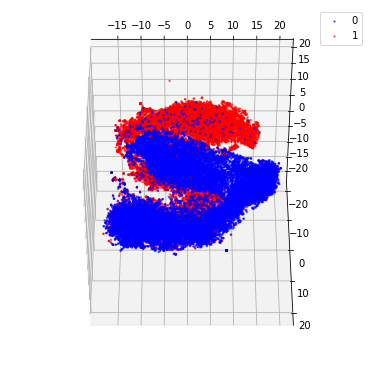

rot1:-180 rot2:-45


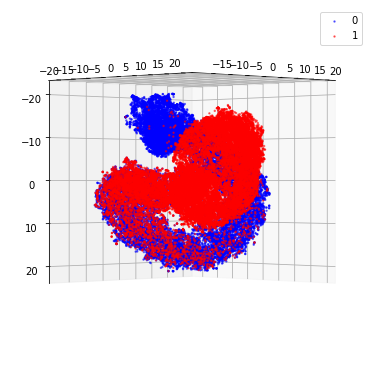

rot1:-135 rot2:-45


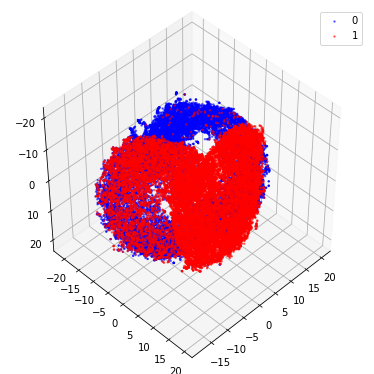

rot1:-90 rot2:-45


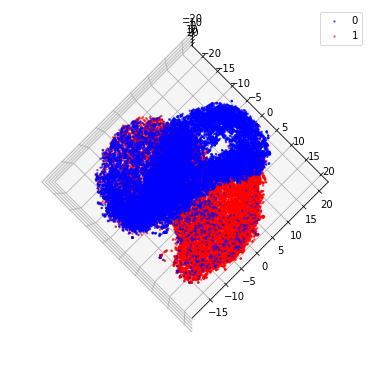

rot1:-45 rot2:-45


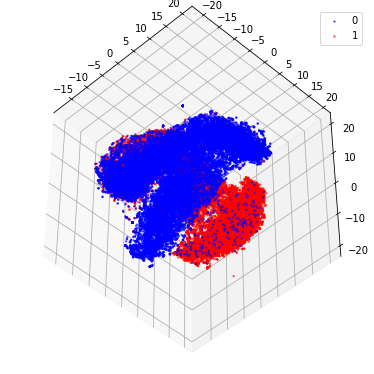

rot1:0 rot2:-45


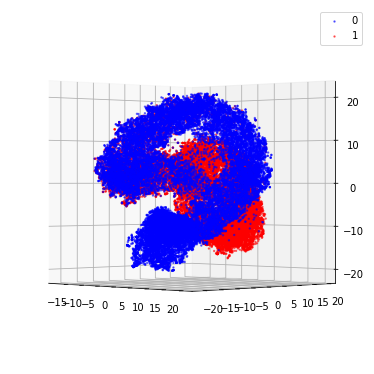

rot1:45 rot2:-45


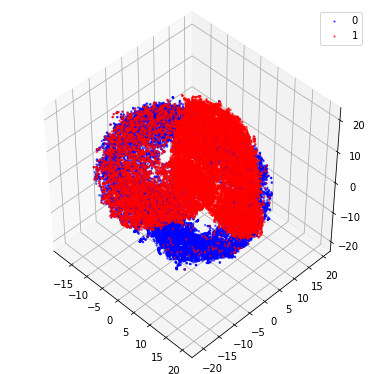

rot1:90 rot2:-45


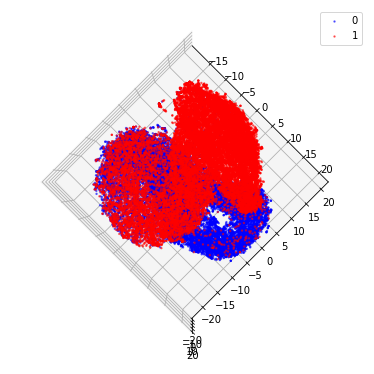

rot1:135 rot2:-45


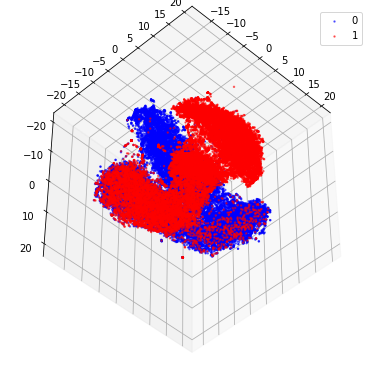

rot1:-180 rot2:0


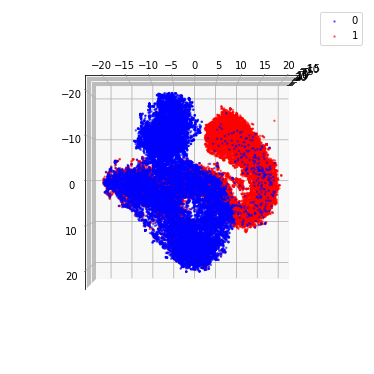

rot1:-135 rot2:0


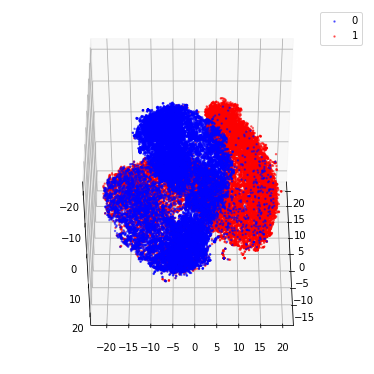

rot1:-90 rot2:0


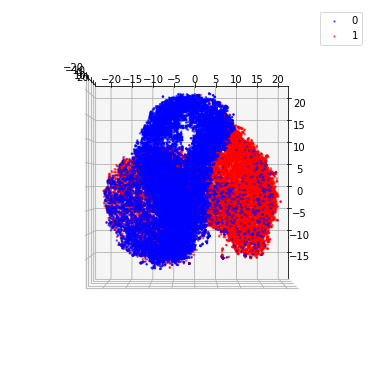

rot1:-45 rot2:0


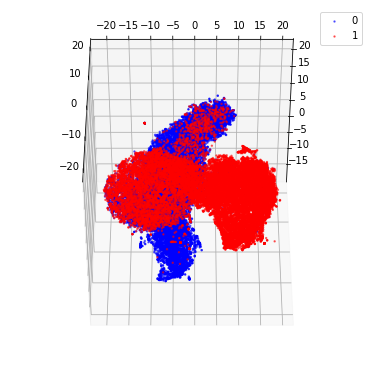

rot1:0 rot2:0


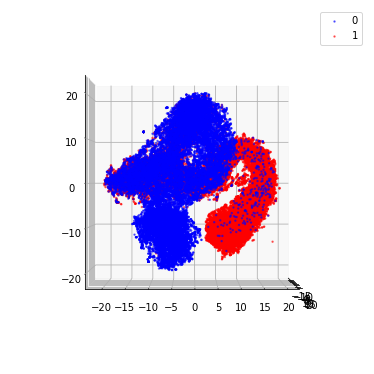

rot1:45 rot2:0


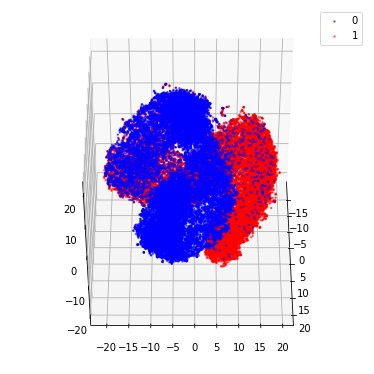

rot1:90 rot2:0


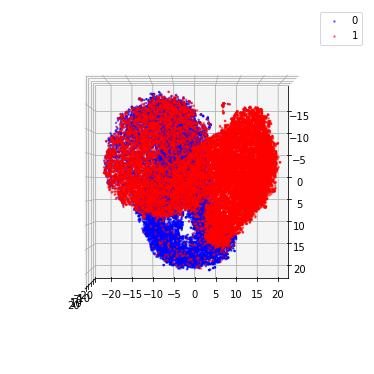

rot1:135 rot2:0


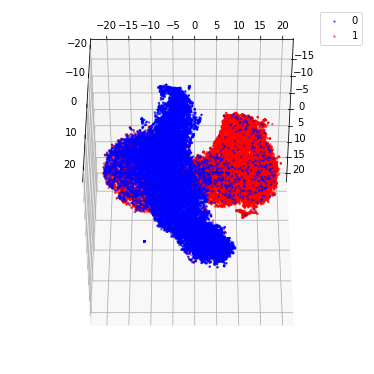

rot1:-180 rot2:45


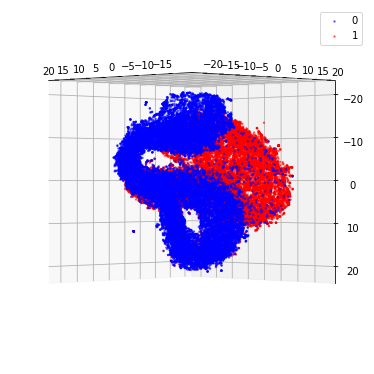

rot1:-135 rot2:45


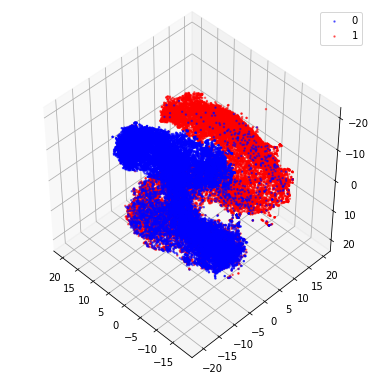

rot1:-90 rot2:45


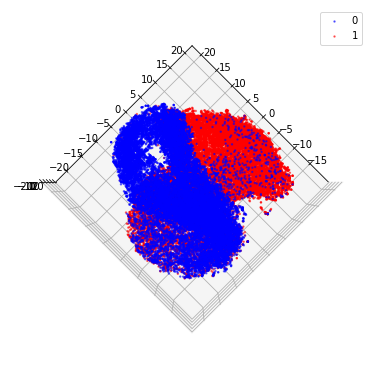

rot1:-45 rot2:45


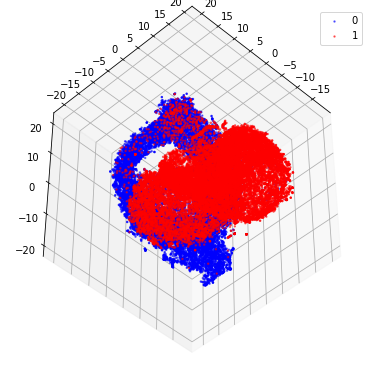

rot1:0 rot2:45


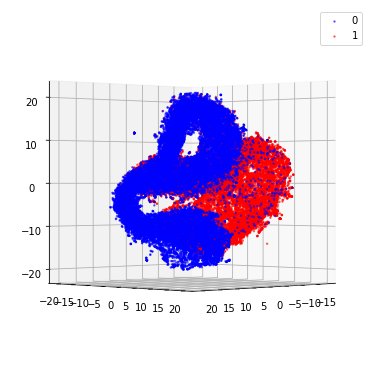

rot1:45 rot2:45


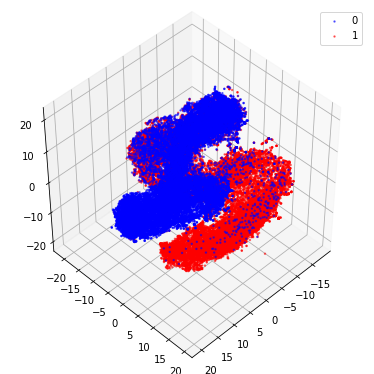

rot1:90 rot2:45


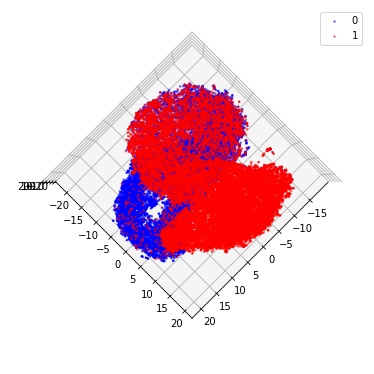

rot1:135 rot2:45


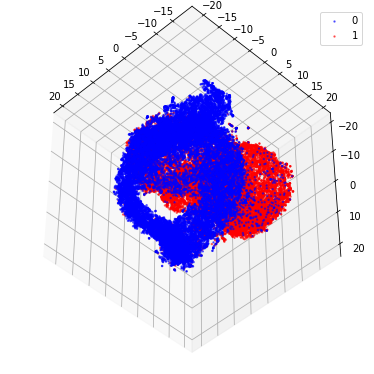

rot1:-180 rot2:90


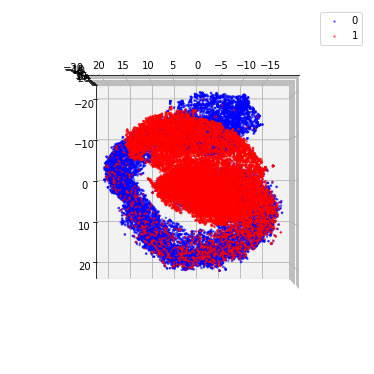

rot1:-135 rot2:90


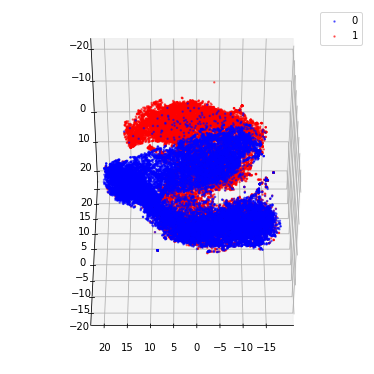

rot1:-90 rot2:90


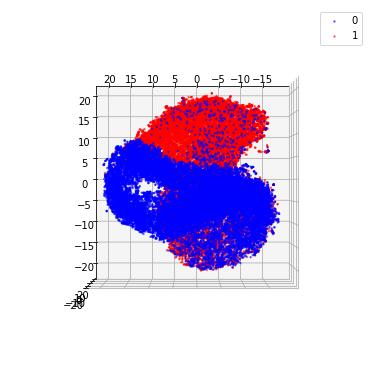

rot1:-45 rot2:90


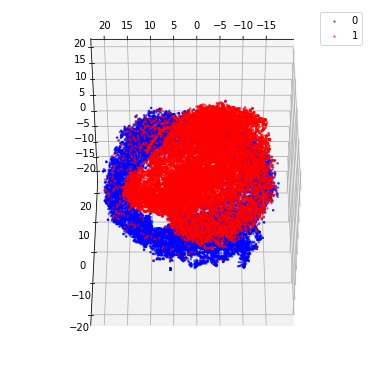

rot1:0 rot2:90


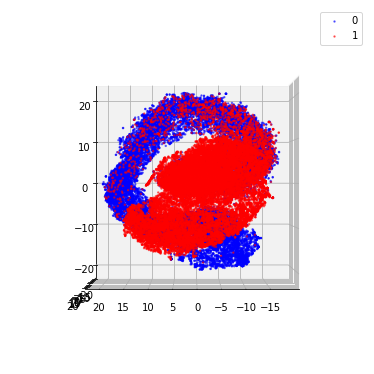

rot1:45 rot2:90


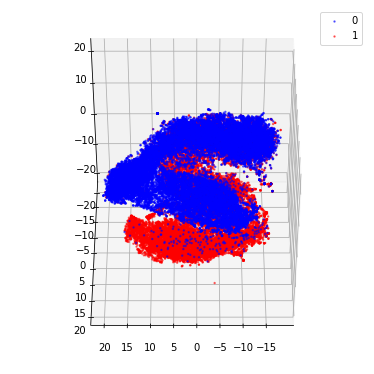

rot1:90 rot2:90


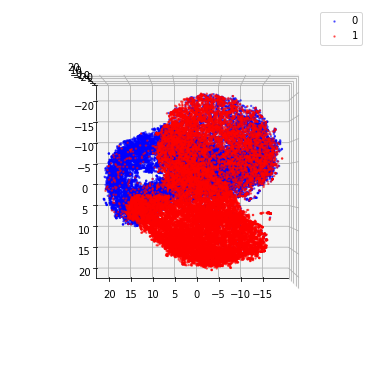

rot1:135 rot2:90


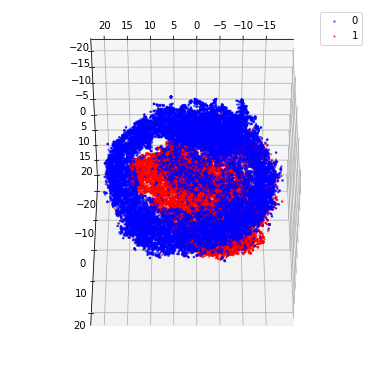

rot1:-180 rot2:135


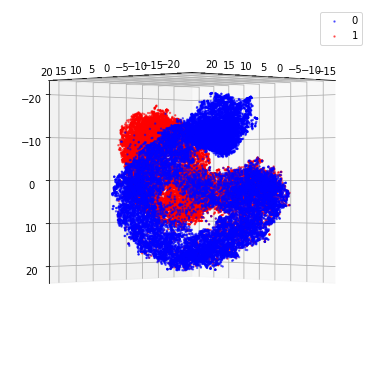

rot1:-135 rot2:135


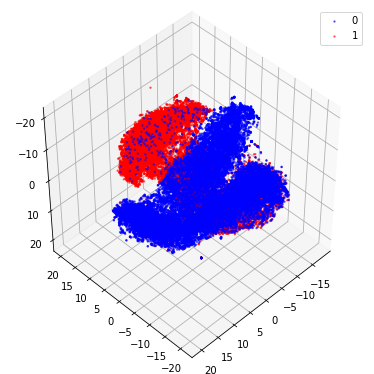

rot1:-90 rot2:135


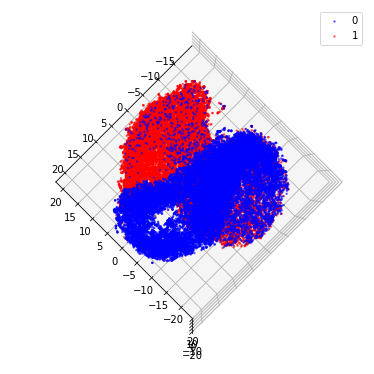

rot1:-45 rot2:135


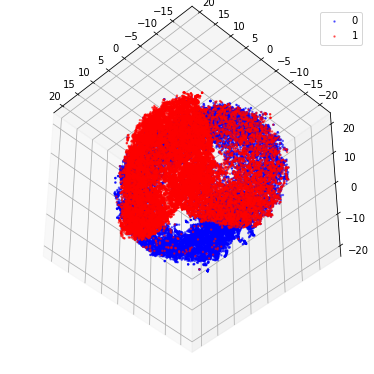

rot1:0 rot2:135


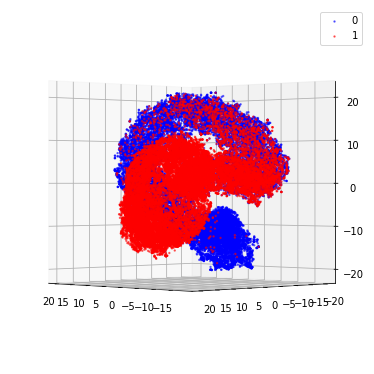

rot1:45 rot2:135


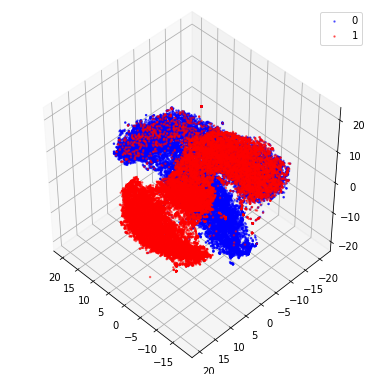

rot1:90 rot2:135


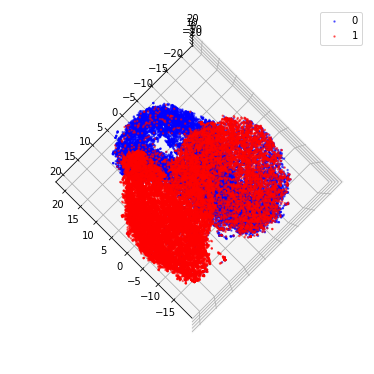

rot1:135 rot2:135


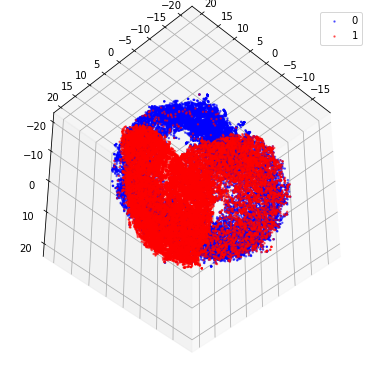

In [0]:
import time
for j in range(-180, 180, 45):
  for i in range(-180,180,45):
  
    get_tsne_plot(i, j)


한번 문장을 입력하면 긍정인지 부정인지 알려주는 함수를 만들어 볼까요? 
-나중에 테스트 해보겠습니다. 아직 진행중...

In [0]:
def sentence_convert_data(data):
    global tokenizer
    indices = []
    ids, segments = tokenizer.encode(data, max_len=SEQ_LEN)
    indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def movie_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = bert_model.predict(data_x)
    predict_answer = np.round(np.ravel(predict), 0).item()
    
    if predict_answer == 0:
      print("부정적인 영화 평가입니다.")
    elif predict_answer == 1:
      print("긍정적인 영화 평가입니다.")

In [0]:
movie_evaluation_predict("나만 이걸 보고 울었는지 모르겠지만 우리나라의 역사의 슬픔과 왕과 신하의 신뢰와 믿음... 그 모든것이 절 슬프게 하였네요... ")

긍정적인 영화 평가입니다.


In [0]:
movie_evaluation_predict("너무잼있어엉 진짜 연기가 예술이고 다시보고싶은영화")

긍정적인 영화 평가입니다.


In [0]:
movie_evaluation_predict("영상미는 좋지만, 스토리와 연출이 너무너무 진부해서 하품100번하다 나왔네요..") 

부정적인 영화 평가입니다.


In [0]:
movie_evaluation_predict("배우들이 맞지 않는 옷을 입은 것처럼 연기력 대부분이 별로였습니다.")

부정적인 영화 평가입니다.


In [0]:
movie_evaluation_predict("평범한 스토리. 볼만한 영상미. 스타워즈도 이제는...")

부정적인 영화 평가입니다.
